# Logistic Regression Exercise

- [Setup](#Setup)
- [Compare Models](#Compare-Models)
    - [Model Creation](#Model-Creation)
    - [Evaluation](#Evaluation)
- [Exploring the C Hyperparameter](#Exploring-the-C-Hyperparameter)

## Setup

In [1]:
import warnings
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.model_selection

import acquire_walkthrough
import prepare_walkthrough
import logistic_regression_util

titanic = acquire_walkthrough.get_titanic_data()

In [2]:
def encode_sex(df):
    '''
    Returns a new dataframe with the ``sex`` column encoded.
    '''
    return df.assign(
        sex=(df.sex == 'female').astype(int)
    )

In [3]:
def get_splits(titanic):
    '''
    Returns X and y for train, validate and test datasets
    '''
    # don't blow away our original data
    titanic = titanic.copy()
    
    # ignore warnings just for this block
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        scaler, encoder, train, test = prepare_walkthrough.prep_titanic(titanic)
    
    # Which features are we going to look at?
    cols = ['survived', 'pclass', 'sex', 'age', 'alone']
    train = train[cols]
    test = test[cols]

    # validate data split
    train, validate = sklearn.model_selection.train_test_split(
        train, train_size=.85, random_state=123
    )

    # split into X and y
    X_train, y_train = train.drop(columns='survived'), train.survived
    X_validate, y_validate = validate.drop(columns='survived'), validate.survived
    X_test, y_test = test.drop(columns='survived'), test.survived
    
    X_train = encode_sex(X_train)
    X_validate = encode_sex(X_validate)
    X_test = encode_sex(X_test)    
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [4]:
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

print('   train: %d rows' % X_train.shape[0])
print('validate: %d rows' % X_validate.shape[0])
print('    test: %d rows' % X_test.shape[0])

   train: 643 rows
validate: 114 rows
    test: 134 rows


## Compare Models

In [5]:
# a dataframe to hold our models' predictions for future comparison
evaluation = pd.DataFrame({
    'actual': y_validate
})

### Model Creation

Note that I've built my notebook such that one cell is one "unit" of model creation.
At the top of every cell I re-call `get_splits` so that I'm free to screw around with the data (e.g. dropping, renaming columns) within that cell, but it will be reset for the next one.
The last step of each cell is storing the model's predictions.

In [6]:
# survived ~ pclass + age
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)
X_train = X_train.drop(columns=['alone', 'sex'])
X_validate = X_validate.drop(columns=['alone', 'sex'])

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
evaluation['survived ~ pclass + age'] = model.predict_proba(X_validate)[:, 1]

In [7]:
# survived ~ pclass + age + sex
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)
X_train = X_train.drop(columns=['alone'])
X_validate = X_validate.drop(columns=['alone'])

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
evaluation['survived ~ pclass + age + sex'] = model.predict_proba(X_validate)[:, 1]

In [8]:
# survived ~ pclass + age + sex + alone
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
evaluation['survived ~ pclass + age + sex + alone'] = model.predict_proba(X_validate)[:, 1]

### Evaluation

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


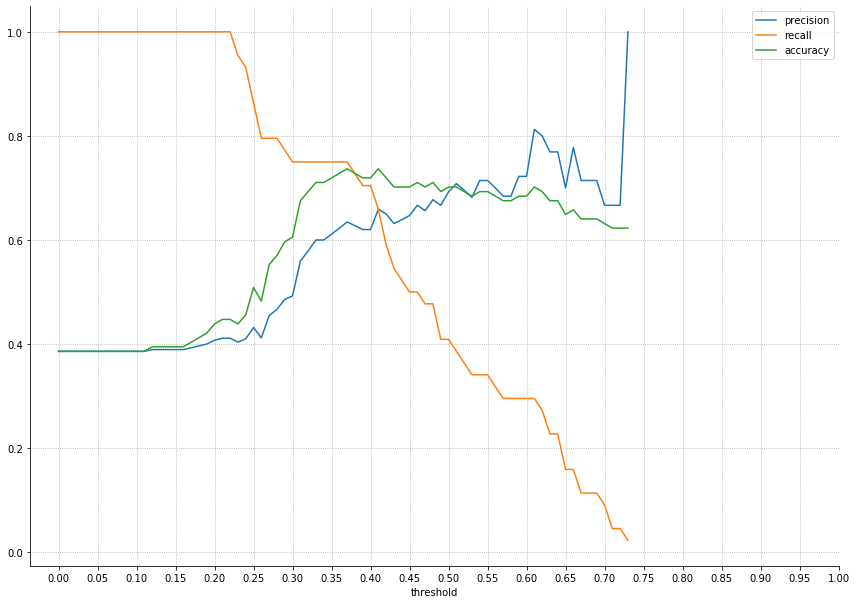

In [9]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age']
)

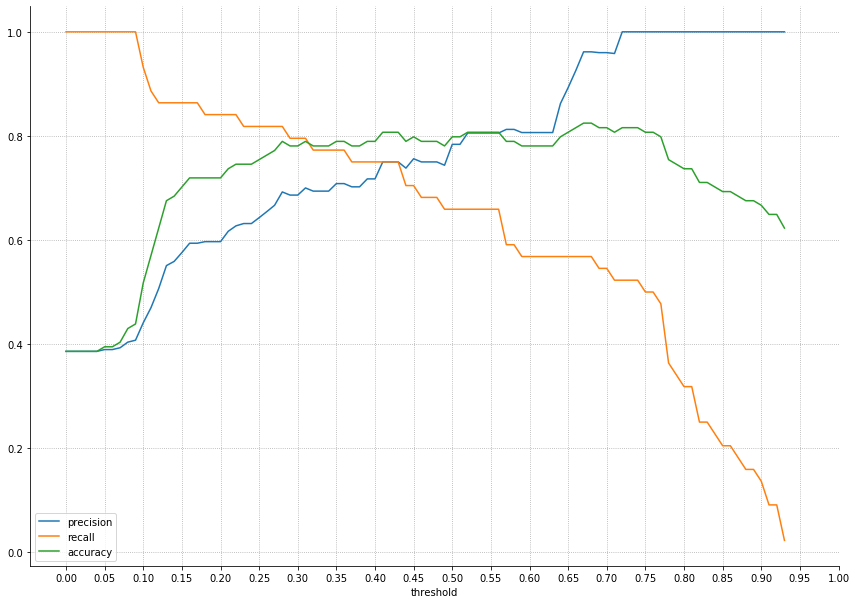

In [10]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age + sex']
)

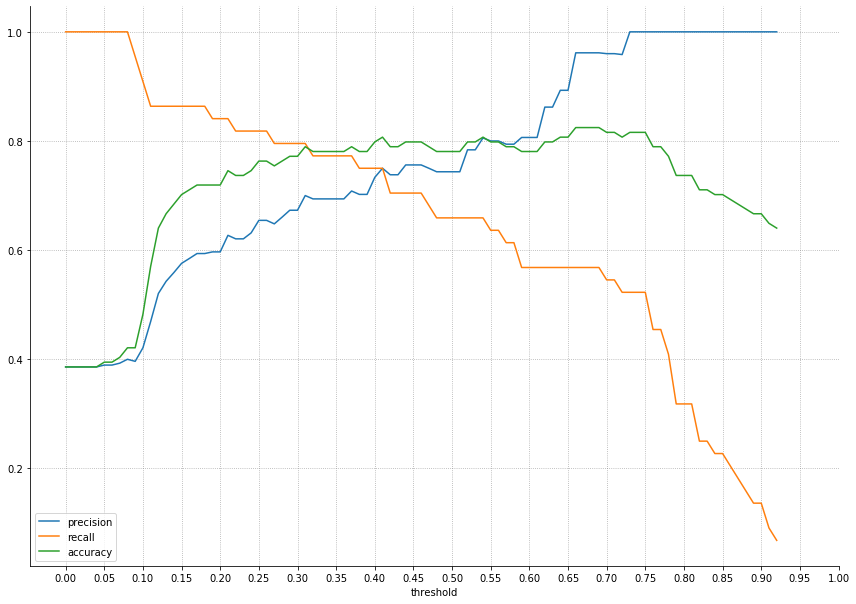

In [11]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age + sex + alone']
)

Clearly the model with more features is better here.

## Exploring the `C` Hyperparameter

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

# TODO: allow for a threshold
# TODO: include precision and recall
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(X_train, y_train)
    accuracy = model.score(X_validate, y_validate)
    coefs = dict(zip(X_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]
(pd.DataFrame(models).round(3).set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of differnt C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3))

,,pclass,sex,age,alone
C,accuracy,,,,
0.001,0.614,-0.074,0.078,-0.004,-0.030
0.01,0.789,-0.379,0.573,-0.053,-0.180
0.1,0.781,-0.755,1.802,-0.465,-0.278
1.0,0.781,-1.033,2.477,-1.782,-0.141
10.0,0.798,-1.133,2.613,-2.546,-0.072
100.0,0.798,-1.147,2.630,-2.664,-0.063
1000.0,0.798,-1.149,2.632,-2.677,-0.062
